In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('drive')
os.chdir('MyDrive')
os.chdir('Project')

# Pathogen detection baseline - Notebook 1
### In this notebook, we will train one baseline model (LogisticRegression) and save it. In notebook 2, we will load the very same model and predict the pathogen(s) (validation dataset)

In [3]:
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import umap
import umap.plot

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, SelectPercentile
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from joblib import dump, load
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA




###  First, some dataset statistics. Then, we will load our training labels (ground truth) and see how distributed it is.

In [4]:
df_y= pd.read_csv('datasets/labels.csv')
df_y['genome_name'].value_counts()

decoy                          815912
burkholderia_pseudomallei        8558
pseudomonas_aeruginosa           7568
mycobacterium_ulcerans           6786
mycobacterium_tuberculosis       5265
staphylococcus_aureus            3412
corynebacterium_ulcerans         2962
corynebacterium_diphtheriae      2885
neisseria_gonorrhoeae            2637
streptococcus_pneumoniae         2600
staphylococcus_pyogenes          2078
Name: genome_name, dtype: int64

### it seems we have a lot of decoy reads (it must be human or commensal species reads all labeled as "decoy")

In [5]:
#snippet to load the training labels and normalize the label predictions. 
#your trained model will predict in this space (0 to 10)
le = preprocessing.LabelEncoder()
le.fit(df_y['genome_name'].unique())
y_index = le.transform(df_y['genome_name'].values)

### In this example, we will load the 6mer profiles dataset and use it as features during our training.

### We have decided to load in a chunk size of 150,000 as we have decided to explore with > 100,000 decoy samples

In [6]:
#to save memory, columns name are stored separately
df_cols = pd.read_csv('datasets/6mer_columns.txt', header=None)

#loading training dataset and including the columns names
# df = pd.read_csv('datasets/perfect_reads_6mer.gz', names=df_cols[0].values.astype(str), sep='\t')

#alternativelly you can convert dataframe columns to float32 first in order to save some memory
#using the following snippet

# Sample 100 rows of data to determine dtypes.
df_test = pd.read_csv('datasets/perfect_reads_6mer.gz', header=None, sep='\t', nrows=100)

float_cols = [c for c in df_test if df_test[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}

#then load the csv in chunks
#
chunksize = 150000
chunks = pd.read_csv('datasets/perfect_reads_6mer.gz', header=None, sep='\t', engine='c', dtype=float32_cols, names=df_cols[0].values.astype(str), chunksize=chunksize)
# this get the first chunksize rows
df = chunks.get_chunk(chunksize)

#from here you can perform your exploratory data analysis per chuck, select the data you want and concatenate later in a new dataframe. 
# the amount of data you will analize is up to you.

In [7]:
df.shape

(150000, 2081)

In [8]:
#we gonna this column as training label later...
df['genome_label'] = y_index[:chunksize]

### We subsampled to species with a minimum number of reads. In this case, all other species will also have 2078 samples. However, based on our research, we have discovered that varying the number of decoys will affect the model trained and hence results. Therefore, there is a function below to vary the number of decoys while keeping the other species at 2078 samples.


In [13]:
sample_size = 2078
def more_decoys(df):
  if df.iloc[0].values[-1]==3:
    return df.sample(100000)
  else:
    return df.sample(sample_size)

df_train = df.groupby('genome_label').apply(more_decoys)

In [14]:
df_train['genome_label'].value_counts()

3     100000
0       2078
1       2078
2       2078
4       2078
5       2078
6       2078
7       2078
8       2078
9       2078
10      2078
Name: genome_label, dtype: int64

### Quick exploratory data analysis
### We will plot a umap of all reduced training dataset and look for any interesting pattern

Understanding our dataset of 2080 kmers

In [51]:
df_train

AAAAAA    AAAAAT    AAAAAG    AAAAAC    AAAATA    AAAATT  \
genome_label                                                                 
0            0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
             0  0.000076  0.000153  0.000000  0.000153  0.000000  0.000076   
             0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
             0  0.000126  0.000126  0.000126  0.000126  0.000251  0.000000   
             0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...                  ...       ...       ...       ...       ...       ...   
10           0  0.002923  0.002505  0.003340  0.002923  0.003340  0.001670   
             0  0.004353  0.002176  0.005441  0.002176  0.002176  0.002176   
             0  0.000000  0.000000  0.000000  0.000000  0.002232  0.002232   
             0  0.000000  0.000000  0.000000  0.000000  0.006536  0.000000   
             0  0.003149  0.003055  0.002632  0.001692  0.001880  0.001974   

                  AAAATG    AAAATC    AAAAGA    AAAAGT  ...    CCAGGG  \
genome_label                                            ...             
0            0  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
             0  0.000076  0.000229  0.000000  0.000000  ...  0.000305   
             0  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
             0  0.000251  0.000000  0.000000  0.000000  ...  0.000754   
             0  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
...                  ...       ...       ...       ...  ...       ...   
10           0  0.001253  0.002505  0.001670  0.002923  ...  0.000418   
             0  0.002176  0.000000  0.005441  0.001088  ...  0.000000   
             0  0.002232  0.006696  0.000000  0.002232  ...  0.000000   
             0  0.006536  0.000000  0.000000  0.000000  ...  0.000000   
             0  0.001598  0.002538  0.002397  0.001081  ...  0.000047   

                  CCACGG  CCTAGG    CCCAGG    CCGAGG    CCCCGG    CCGCGG  \
genome_label                                                               
0            0  0.000000     0.0  0.000000  0.000000  0.004016  0.000000   
             0  0.000534     0.0  0.000381  0.000686  0.000458  0.002288   
             0  0.000000     0.0  0.000000  0.000000  0.000000  0.000000   
             0  0.000503     0.0  0.000126  0.000377  0.000503  0.003018   
             0  0.000000     0.0  0.000000  0.001767  0.000000  0.000000   
...                  ...     ...       ...       ...       ...       ...   
10           0  0.000000     0.0  0.000418  0.000000  0.000000  0.000000   
             0  0.000000     0.0  0.000000  0.001088  0.000000  0.000000   
             0  0.000000     0.0  0.000000  0.000000  0.000000  0.000000   
             0  0.000000     0.0  0.000000  0.000000  0.000000  0.000000   
             0  0.000094     0.0  0.000047  0.000047  0.000000  0.000000   

                  CCCGGG  IGNORE  genome_label  
genome_label                                    
0            0  0.008032     NaN             0  
             0  0.000153     NaN             0  
             0  0.000000     NaN             0  
             0  0.000754     NaN             0  
             0  0.000000     NaN             0  
...                  ...     ...           ...  
10           0  0.000000     NaN            10  
             0  0.000000     NaN            10  
             0  0.000000     NaN            10  
             0  0.000000     NaN            10  
             0  0.000000     NaN            10  

[120780 rows x 2082 columns]

In [62]:
sample_size = 2078
def more_decoys(df):
  if df.iloc[0].values[-1]==3:
    return df.sample(10000)
  else:
    return df.sample(sample_size)

df_train_umap = df.groupby('genome_label').apply(more_decoys)

In [ ]:
# the last column of our 6mer training dataset can be ignored, it is only NaN and this column is not considered a 6mer.
mapper = umap.UMAP().fit(df_train_umap.iloc[:,:-2])

In [ ]:
labels_tc =le.inverse_transform(df_train['genome_label'])

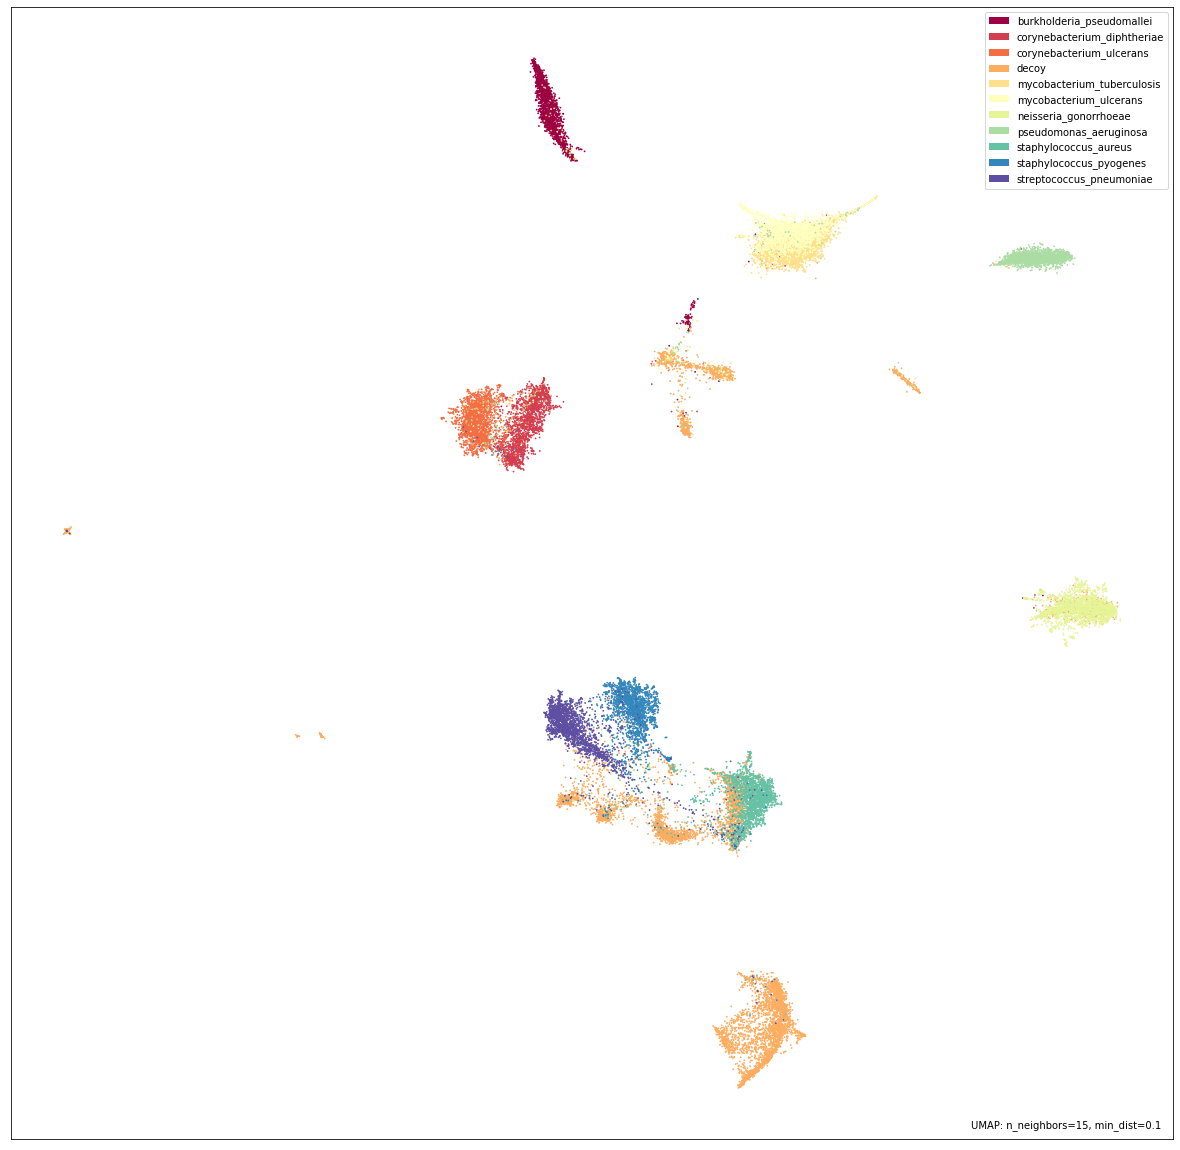

In [ ]:
ax = umap.plot.points(mapper, labels=labels_tc,  width=1500, height=1500)


2D Projection of Subsample of data used to train Random Forest Classifier. 10,000 decoy reads and 2078 reads from each of 10 pathogens were drawn without replacement. 

#### We have increased the sample size of the decoy to 10000, although we will be using an even greater number of decoys. From the graph, we can easily observe that decoy reads are present throughout the plot and are even present within the clusters of other species. We have observed this and hence decided to increase our decoy sample size in our training data to account for all these decoy reads. This will also train our model to better recognise the differences between the decoys and the species.

### Baseline model provided

In [ ]:
%timeit
from sklearn.model_selection import GridSearchCV
parameters_lr = [{'penalty':['l1','l2'],'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

regr = LogisticRegression(random_state=2022, solver='saga', n_jobs=-1, class_weight='balanced', max_iter=100, verbose=1)

grid_search_lr = GridSearchCV(estimator = regr,
                           param_grid = parameters_lr,
                           scoring = 'accuracy',
                           cv = 3,
                           n_jobs = -1)

# the last column of our 6mer training dataset can be ignored, it only NaN and this column is not considered a 6mer.
grid_search_lr.fit(df_train.iloc[:,:-1].values , df_train['genome_label'].astype(int).values)
best_accuracy_lr = grid_search_lr.best_score_
best_paramaeter_lr = grid_search_lr.best_params_  
print("Best Accuracy of LR: {:.2f} %".format(best_accuracy_lr.mean()*100))
print("Best Parameter of LR:", best_paramaeter_lr)

Baseline model hyperparameter tuning

In [ ]:
#linear classifier using scikit-learn
# Create linear regression object
#Best Parameter of LR: {'C': 100, 'penalty': 'l1'}
regr = LogisticRegression(C=100,penalty='l1',random_state=2022, solver='saga', n_jobs=-1, class_weight='balanced', max_iter=1000, verbose=1)
%timeit
# Train the model using the training sets
regr.fit(df_train.iloc[:,:-1].values , df_train['genome_label'].astype(int).values)


### We first tried to reduce the dimensionality of the dataset using PCA and then running KNearestNeighbour algorithm

We reduced the dimensionality of the dataset using PCA and attempted to obtain the best parameter for n_neighbours

In [ ]:
pca = PCA(n_components=0.90)
pca.fit(df_train.iloc[:, :-2])
df_train_pca = pca.transform(df_train.iloc[:, :-2])

# pk.dump(pca, open("pca.pkl", "wb")) #dumping to use it on validation data 

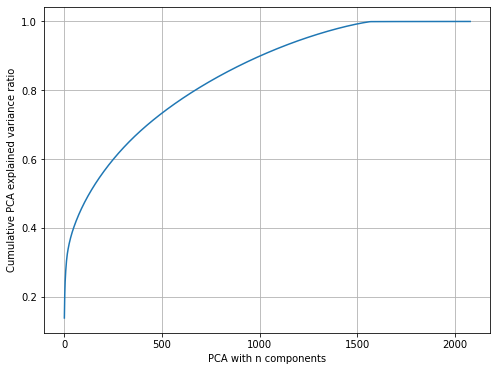

In [15]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
pca = PCA()
pcaresult = pca.fit_transform(df_train.iloc[:,:-2].values, df_train['genome_label'].astype(int).values)
y_val = []
cur=0
for i in range(2080):
  cur += pca.explained_variance_ratio_[i]
  y_val.append(cur)
figure(figsize=(8,6))
plt.ylabel("Cumulative PCA explained variance ratio")
plt.xlabel("PCA with n components")
plt.plot(range(2080),y_val)
plt.grid()
plt.show()

Cumulative Explained Variance of data for n-best PCA components. 0.90 explained variance with 922 PCs, 0.95 explained variance achieved with 1622 PCs. 

In [23]:
y = df_train['genome_label'].astype(int).values
x = df_train_pca
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1) # 70% training and 30% test

knn = neighbors.KNeighborsClassifier(weights= 'distance', n_neighbors= 2, algorithm= 'auto')
knn.fit(x_train,y_train)
y_pred = knn.predict(x_test)
print(f"Precision for :", metrics.precision_score(y_test, y_pred, average = "micro"))


Precision for : 0.9752166473477949


Although the precision scores appear to be very good in the test set, it performed poorly in the validation set and therefore we sought out alternative algorithms

### Preprocessing data by selecting K best features

In [9]:
sample_size = 2078
def more_decoys(df):
  if df.iloc[0].values[-1]==3:
    return df.sample(2078)
  else:
    return df.sample(sample_size)

df_train = df.groupby('genome_label').apply(more_decoys)

In [ ]:
k = [500,600,700,800,900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
precision = []
for i in k:
  X_new = SelectKBest(chi2, k=i).fit(df_train.iloc[:, :-2], df_train["genome_label"])
  feature_ids = X_new.get_support(indices=True)
  feature_names = df_train.columns[feature_ids]
  indexList = [i for i in feature_names]

  y = df_train['genome_label'].astype(int).values
  x = df_train[indexList].values
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1) # 70% training and 30% test

  rfc = RandomForestClassifier(n_estimators= 200, min_samples_split= 20)
  rfc.fit(x_train,y_train)
  y_pred = rfc.predict(x_test)
  precision.append(metrics.precision_score(y_test, y_pred, average = "micro"))

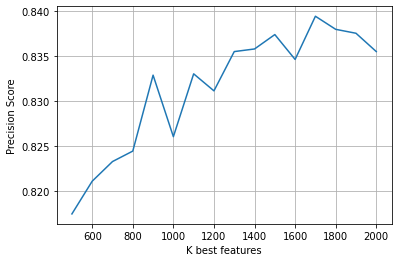

In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.ylabel("Precision Score")
plt.xlabel("K best features")
plt.plot(k,precision)
plt.grid()
plt.show()

Random Forest classifiers trained with k best features ranked by chi-square test found relatively similar precision scores between 0.80 and 0.85.

We would select the 900 best features. This is to reduce the number of features to reduce computational cost as well as prevent overfitting if the model is trained with more features.

### Deciding to go with Random Forest Classifier with 900 attributes.

We have tested on different samples of decoy, but have decided on 100,000 decoy samples

In [30]:
sample_size = 2078
def more_decoys(df):
  if df.iloc[0].values[-1]==3:
    return df.sample(100000)
  else:
    return df.sample(sample_size)

df_train = df.groupby('genome_label').apply(more_decoys)

In [52]:
X_new = SelectKBest(chi2, k=900).fit(df_train.iloc[:, :-2], df_train["genome_label"])
feature_ids = X_new.get_support(indices=True)
feature_names = df_train.columns[feature_ids]
indexList = [i for i in feature_names]
indexList

['AAAAAA',
 'AAAAAT',
 'AAAAAG',
 'AAAAAC',
 'AAAATA',
 'AAAATT',
 'AAAATG',
 'AAAATC',
 'AAAAGA',
 'AAAAGT',
 'AAAAGG',
 'AAAAGC',
 'AAAACA',
 'AAAACT',
 'AAAACG',
 'AAAACC',
 'AAATAA',
 'AAATAT',
 'AAATAG',
 'AAATAC',
 'AAATTA',
 'AAATTT',
 'AAATTG',
 'AAATTC',
 'AAATGA',
 'AAATGT',
 'AAATGG',
 'AAATCA',
 'AAATCT',
 'AAATCG',
 'AAATCC',
 'AAAGAA',
 'AAAGAT',
 'AAAGAG',
 'AAAGTA',
 'AAAGTT',
 'AAAGTG',
 'AAAGGA',
 'AAAGCA',
 'AAAGCT',
 'AAAGCG',
 'AAACAA',
 'AAACAT',
 'AAACAG',
 'AAACTA',
 'AAACTT',
 'AAACGG',
 'AAACGC',
 'AAACCA',
 'AAACCG',
 'AATAAA',
 'AATAAT',
 'AATAAG',
 'AATAAC',
 'AATATA',
 'AATATT',
 'AATATG',
 'AATATC',
 'AATAGA',
 'AATAGT',
 'AATACA',
 'AATACT',
 'AATACG',
 'AATTAA',
 'AATTAT',
 'AATTAG',
 'AATTAC',
 'AATTTA',
 'AATTTG',
 'AATTTC',
 'AATTGA',
 'AATTGT',
 'AATTCA',
 'AATTCT',
 'AATGAA',
 'AATGAT',
 'AATGTA',
 'AACATT',
 'AATGGA',
 'AATGGT',
 'AATGCG',
 'AATCAA',
 'AATCAT',
 'AATCTA',
 'AAGATT',
 'AATCGA',
 'AATCGT',
 'AATCGG',
 'AATCGC',
 'AATCCG',
 'AAGAAA',

Using the best 900 attributes, we trained on the entire dataset with the number of decoys we have decided on. We have also trained it with bootstrapping to avoid overfitting of the model.



In [ ]:
rfc = RandomForestClassifier(n_estimators= 200, min_samples_split= 20, bootstrap = True)
rfc.fit(df_train[indexList],df_train["genome_label"])

Saving our model and feature list
//commented out to prevent overwriting of models

In [42]:
#comment out to prevent overwriting of models
# with open("100kdecoysbootstrap", "wb") as fp:
#     pk.dump(indexList, fp)

# dump(rfc, 'models/rfcmodel100kdecoysbootstrap.joblib')

['models/features100kbootstrap.joblib']

### We want to identify the threshold that gives us the best results so we will iterate from 0.1 to 1 with intervals of 0.05

In [70]:
df_y = pd.read_csv('datasets/labels.csv', index_col=0)
le = preprocessing.LabelEncoder()
le.fit(df_y['genome_name'].unique())

model = load('models/rfcmodel100kdecoysbootstrap.joblib')
features = pk.load(open("features100kdecoysbootstrap", "rb"))

def precision_per_patient(patient_id, preds):
    df_true = pd.read_csv('datasets/validation/val{}_labels.txt'.format(patient_id))
    tp,fp, tp_labels=0,0, df_true['true_label'].shape[0]
    # if don't predict any pathogen, it means there is only decoy in the test dataset (your prediction)
    if len(preds) == 0:
        preds = ['decoy']
    for item in np.unique(preds):
        if item in df_true['true_label'].values:
            tp+=1
        else:
            fp+=1
    #you have to predict all labels correctly, but you are penalized for any false positive
    return tp/(tp_labels+fp)

best_average_precision, best_threshold = 0, 0

arr = np.arange(0.10, 1.01, 0.05)
average_precision = []

for i in arr:
  threshold = i

  all_precision = []
  for patient_id in range(1,17):
      df_cols = pd.read_csv('datasets/6mer_columns.txt', header=None)
      df_test = pd.read_csv('datasets/validation/val{}_6mer.gz'.format(patient_id), header=None, names=df_cols[0].values.astype(str), sep='\t')

      df_test = df_test[features]

      y_predprob = model.predict_proba(df_test.values)

      final_predictions = le.inverse_transform(np.unique([np.argmax(item) for item in y_predprob if len(np.where(item>= threshold)[0]) >=1]))

      #my pathogens dectected, decoy will be ignored
      final_predictions = [item for item in final_predictions if item !='decoy']    
      
      precision = precision_per_patient(patient_id, final_predictions)
      all_precision.append(precision)


  sum = 0
  for j in all_precision:
    sum += j

  if sum/16 > best_average_precision:
    best_average_precision, best_threshold = sum/16, threshold
  average_precision.append(sum/16)


In [71]:
print(f"The threshold of {best_threshold} has the best_average_precision of {best_average_precision}.")

The threshold of 0.5500000000000002 has the best_average_precision of 0.953125.


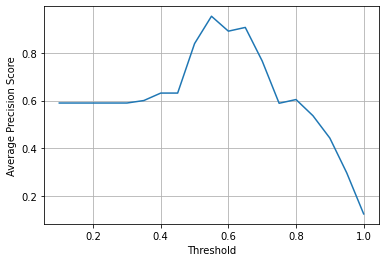

In [72]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.ylabel("Average Precision Score")
plt.xlabel("Threshold")
plt.plot(arr ,average_precision)
plt.grid()
plt.show()

Random Forest classifier predictions were filtered using different thresholds for probability and scored based on the average precision score when tested with the validation dataset. 

## Testing our model with validation set

In [5]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import pickle as pk
from joblib import dump, load
from sklearn import preprocessing
import csv

df_y = pd.read_csv('datasets/labels.csv', index_col=0)
le = preprocessing.LabelEncoder()
le.fit(df_y['genome_name'].unique())

model = load('models/rfcmodel100kdecoysbootstrap.joblib')
features = pk.load(open("features100kdecoysbootstrap", "rb"))

In [6]:
def precision_per_patient(patient_id, preds):
    df_true = pd.read_csv('datasets/validation/val{}_labels.txt'.format(patient_id))
    tp,fp, tp_labels=0,0, df_true['true_label'].shape[0]
    print('my predition(s) for patient {}:'.format(patient_id))
    print(preds)
    print('true pathogen')
    print(df_true['true_label'].values)
    # if don't predict any pathogen, it means there is only decoy in the test dataset (your prediction)
    if len(preds) == 0:
        preds = ['decoy']
    for item in np.unique(preds):
        if item in df_true['true_label'].values:
            tp+=1
        else:
            fp+=1
    #you have to predict all labels correctly, but you are penalized for any false positive
    return tp/(tp_labels+fp)

In [7]:
threshold = 0.55

all_precision = []
for patient_id in range(1,17):
    print('predicting for patient {}'.format(patient_id))
    df_cols = pd.read_csv('datasets/6mer_columns.txt', header=None)
    df_test = pd.read_csv('datasets/validation/val{}_6mer.gz'.format(patient_id), header=None, names=df_cols[0].values.astype(str), sep='\t')

    df_test = df_test[features]

    y_predprob = model.predict_proba(df_test.values)

    final_predictions = le.inverse_transform(np.unique([np.argmax(item) for item in y_predprob if len(np.where(item>= threshold)[0]) >=1]))

    a = [np.argmax(item) for item in y_predprob if len(np.where(item>= threshold)[0]) >=1]

    #my pathogens dectected, decoy will be ignored
    final_predictions = [item for item in final_predictions if item !='decoy']    
    
    precision = precision_per_patient(patient_id, final_predictions)
    print('precision: {}'.format(precision))
    all_precision.append(precision)



predicting for patient 1
my predition(s) for patient 1:
['staphylococcus_aureus']
true pathogen
['staphylococcus_aureus']
precision: 1.0
predicting for patient 2
my predition(s) for patient 2:
['staphylococcus_pyogenes']
true pathogen
['staphylococcus_pyogenes']
precision: 1.0
predicting for patient 3
my predition(s) for patient 3:
['burkholderia_pseudomallei', 'corynebacterium_ulcerans']
true pathogen
['burkholderia_pseudomallei' 'corynebacterium_ulcerans']
precision: 1.0
predicting for patient 4
my predition(s) for patient 4:
['pseudomonas_aeruginosa']
true pathogen
['pseudomonas_aeruginosa']
precision: 1.0
predicting for patient 5
my predition(s) for patient 5:
['corynebacterium_diphtheriae', 'corynebacterium_ulcerans']
true pathogen
['corynebacterium_diphtheriae']
precision: 0.5
predicting for patient 6
my predition(s) for patient 6:
['streptococcus_pneumoniae']
true pathogen
['streptococcus_pneumoniae']
precision: 1.0
predicting for patient 7
my predition(s) for patient 7:
['mycob

Getting results

In [47]:
sum = 0
for i in all_precision:
  sum += i

print(f"All Precision: {all_precision}")
print(f"Average precision: {sum/len(all_precision)}")

All Precision: [1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 1.0, 1.0]
Average precision: 0.953125


Our RFC model seems to perform very well with a very high average precision of 0.953125. We will use this model for our test set.

### We will test our model with the test set to get the final results

Loading our data and model

In [48]:
df_y = pd.read_csv('datasets/labels.csv', index_col=0)
le = preprocessing.LabelEncoder()
le.fit(df_y['genome_name'].unique())

model = load('models/rfcmodel100kdecoysbootstrap.joblib')
features = pk.load(open("features100kdecoysbootstrap", "rb"))

Obtaining results

In [50]:
threshold = 0.55
for patient_id in range(1,8):
    df_cols = pd.read_csv('datasets/6mer_columns.txt', header=None)
    df_test = pd.read_csv('datasets/test/test{}_6mer.gz'.format(patient_id), header=None, names=df_cols[0].values.astype(str), sep='\t')
    df_test = df_test[features]
    y_predprob = model.predict_proba(df_test.values)

    final_predictions = le.inverse_transform(np.unique([np.argmax(item) for item in y_predprob if len(np.where(item>= threshold)[0]) >=1]))

    #my pathogens dectected, decoy will be ignored
    final_predictions = [item for item in final_predictions if item !='decoy']

    # a = np.unique([np.argmax(item) for item in y_predprob if len(np.where((item - threshold) > 0)[0]) >=1])
    if len(final_predictions) ==0:
      final_predictions.append("decoy")

    print("pred_label")
    for i in final_predictions:
      print(i)
    print("\n")



pred_label
pseudomonas_aeruginosa


pred_label
pseudomonas_aeruginosa


pred_label
corynebacterium_ulcerans
pseudomonas_aeruginosa


pred_label
mycobacterium_tuberculosis
mycobacterium_ulcerans
staphylococcus_pyogenes


pred_label
decoy


pred_label
burkholderia_pseudomallei
corynebacterium_diphtheriae
mycobacterium_tuberculosis
mycobacterium_ulcerans
pseudomonas_aeruginosa


pred_label
decoy




Final prediction on seven patient datasets